In [1]:
import numpy as np
from math import pi
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.waveguide import Waveguide
from gdshelpers.parts.coupler import GratingCoupler
from gdshelpers.parts.resonator import RingResonator
from gdshelpers.parts.splitter import Splitter
from gdshelpers.layout import GridLayout
from gdshelpers.parts.marker import CrossMarker
from gdshelpers.parts.marker import SquareMarker
from gdshelpers.helpers.positive_resist import convert_to_positive_resist
from gdshelpers.parts.port import Port
from shapely.geometry import Polygon
from shapely.affinity import scale
from shapely.affinity import translate
from shapely.affinity import rotate
from gdshelpers.geometry import geometric_union
from gdshelpers.helpers.under_etching import create_holes_for_under_etching
from gdshelpers.geometry.ebl_frame_generators import raith_marker_frame
from gdshelpers.parts.text import Text
from shapely.geometry import Point

In [2]:
# Import help functions written by I-Tung
import make_displaced_IDT_pair
import make_zno_pad
import make_SOS_Optomechanic_Rings_bend_Input_acoustic

In [3]:
# Parameters to change

# The vertical displacement distance between the two IDT (left with respect to right)
y_displacement_for_IDT = -50 #um

# sweep 1 is designated to the acoustic coupling gap
sweep1 = 0.1 #um

# sweep 2 is designated to the acoustic waveguide propagation length
sweep2 = 1000 #um

# Caution:
Below codes are functions with prefixed parameters, so only change when neccessary.

In [4]:
#Make the IDT fingers

# Modified from for the BGaP OMR paper (before 2023-04-17): figer_widths=0.5017, number_of_pairs=80, IDT_Aperature=15, prop_length=200+160+300+200
# New parameters for Si-on-sapphire substrates (2023-04-20): figer_widths=0.25, number_of_pairs=65, IDT_Aperature=100, prop_length=sweep1
# Note on prop length, for rings the proplength needs to be longer add 500 instead of 300: 200+160+300 to ACWG_ONLY:200+160+300 RR:200+160+500 , MZI 200+160+200 , ORR_BENT = 200+160+300
# Figer_width = 1/4 of acoustic wavelength

IDT_1, IDT_1_bigpad, \
IDT_2, IDT_2_bigpad, \
top_right_x, y_mid_IDT, shift_2, \
right_top_small_pad_TL_X, right_top_small_pad_TL_Y,\
left_x_coord_TR, left_y_coord_TR = make_displaced_IDT_pair.make_displaced_IDT_pairs(figer_widths=0.45, number_of_pairs=80,
                                                                    IDT_Aperature=15, prop_length= 200+300+100+50, y_displacement= y_displacement_for_IDT)
# For 2.5 GHz IDT, 1/4 wavelength = 0.45 um



In [5]:
# Make ZnO pads
ZnO_pad_R, ZnO_pad_L = make_zno_pad.make_ZnO_pads(zno_pad_x_length=350,
                        right_top_small_pad_TL_X = right_top_small_pad_TL_X,
                        right_top_small_pad_TL_Y= right_top_small_pad_TL_Y,
                                    pad_width = 90+10,
                                    left_x_coord_TR =left_x_coord_TR)




In [6]:
# Make Optomechanic RingRes bending inputs
# To control if optical WG is included, modified the function inside "make_Optomechanic_Rings_bend_Input_acoustic"
OM_Ring, op_wg_right, Aco_wg, delta_y, tapered_coord_right, tapered_coord_left, \
acoustic_bent_radius, ac_bend_angle_rad, y0_bend, y0_og, ring_origin = make_SOS_Optomechanic_Rings_bend_Input_acoustic.make_Optomechanic_Ring_bend(init_width=15,
                                                                                            fin_width=1.2,
                                                                                            prop_length= sweep2 ,#200 - 5 + 300,
                                                                                            # For rings the proplength needs to be longer :500
                                                                                            tapered_length=100,
                                                                                            top_right_x=top_right_x - 15,
                                                                                            # -15 is to align the bent waveguide
                                                                                            y_mid_IDT=y_mid_IDT,
                                                                                            L_IDT_area=shift_2,
                                                                                            aco_Gap = sweep1,
                                                                                            op_Gap=0.07,
                                                                                            ring_radius = 50,
                                                                                            y_displacement= y_displacement_for_IDT)



In [7]:
# Align the IDT and the acoustic waveguide
# Right IDT
IDT_1 = translate(IDT_1, xoff= tapered_coord_right[0] - top_right_x)
IDT_1_bigpad = translate(IDT_1_bigpad, xoff= tapered_coord_right[0] - top_right_x)
ZnO_pad_R = translate(ZnO_pad_R, xoff= tapered_coord_right[0] - top_right_x)

# Left IDT
IDT_2 = translate(IDT_2, xoff= tapered_coord_left[0] - left_x_coord_TR, yoff = tapered_coord_left[1] - y0_bend)
IDT_2_bigpad = translate(IDT_2_bigpad, xoff= tapered_coord_left[0] - left_x_coord_TR, yoff = tapered_coord_left[1]- y0_bend)
ZnO_pad_L = translate(ZnO_pad_L, xoff= tapered_coord_left[0] - left_x_coord_TR, yoff = tapered_coord_left[1]- y0_bend)

# ZnO pads (with buffer)
One_side_ZnO_under_pads = geometric_union([ZnO_pad_L, ZnO_pad_R, IDT_1_bigpad, IDT_2_bigpad])
One_side_ZnO_under_pads = One_side_ZnO_under_pads.buffer(6)

In [8]:
# toogle on/off the accomodate for bent acoustic waveguide
accomodatae_for_bent_acoustic_wg = True
if accomodatae_for_bent_acoustic_wg == True:
    """ACCOMMODATE FOR BENT ACOUSTIC WG, COMMENT OUT IF NOT USING BENT AC WG"""
    bent_radius = acoustic_bent_radius
    y_delta_by_bending = bent_radius*(1-np.cos(ac_bend_angle_rad))

    shift_ring1 = y0_bend- y0_og
    shift_ring2 = y0_og - y_mid_IDT

    OM_Ring = translate(OM_Ring, yoff = -shift_ring1 + 5.3 - 0.55) #0.55 is a arbitrary number to shift the ring


In [9]:
cell_name = '01'
cell = Cell('SIMPLE_RES_DEVICE r={:.4f} g={:.4f}'.format(sweep1, sweep2))

# Add name to cell
text = Text(origin=[ top_right_x - sweep2, -65], height=20, text=str(cell_name), alignment='left-bottom')
# Add the parts to the cell
cell.add_to_layer(1, convert_to_positive_resist( [OM_Ring],  buffer_radius=10), text)
cell.add_to_layer(2, One_side_ZnO_under_pads)
cell.add_to_layer(3, IDT_1, IDT_2)
cell.add_to_layer(4, IDT_1_bigpad, IDT_2_bigpad)

print('The ring center coordinate is at: ', ring_origin)

The ring center coordinate is at:  [-943.4  -51.3]


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


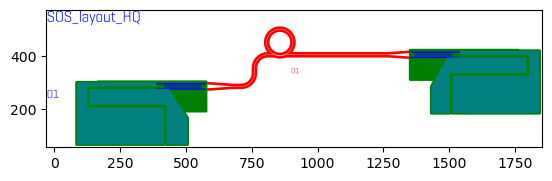

In [10]:
# Generate and show the layout
layout_name = 'SOS_layout_HQ'
layout = GridLayout(title=layout_name, frame_layer=0, text_layer=3, region_layer_type=None,
                        horizontal_spacing= -25, vertical_spacing= -75)
layout.begin_new_row('01')
layout.add_to_row(cell)
layout_cell, mapping = layout.generate_layout()
layout_cell.show()

In [11]:
layout_cell.save('test1.gds')

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/gdshelpers/geometry/shapely_adapter.py:116: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  poly._gdsh_n_points = len(poly.exterior.coords) + sum([len(shapely.geometry.LinearRing(x).coords) for x
